In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the
    # unserialized graph_def
    with tf.io.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="")
    return graph

In [41]:
def draw_box(frame, box, width, height):
    '''
    Draw bounding boxes onto the frame.
    '''
    ymin = int(box[0] * height)
    xmin = int(box[1] * width)
    ymax = int(box[2] * height)
    xmax = int(box[3] * width)
    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    return frame


def inference(image):
    image = cv2.resize(image, (300, 300))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, 0)

    with tf.compat.v1.Session(graph=model_graph) as sess:
        output_tensors = sess.run(outputs, feed_dict={'image_tensor:0': image})
    return output_tensors

In [4]:
model_graph = load_graph(r"./models/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb")

outputs = [
    model_graph.get_tensor_by_name("detection_boxes:0"),
    model_graph.get_tensor_by_name("detection_scores:0"),
    model_graph.get_tensor_by_name("num_detections:0"),
    model_graph.get_tensor_by_name("detection_classes:0")
]

CPU times: user 1h 28min 24s, sys: 33min 8s, total: 2h 1min 33s
Wall time: 1h 56min 43s


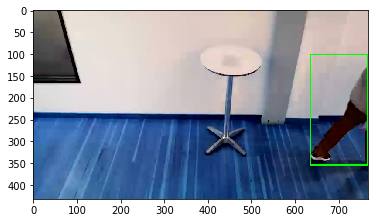

In [115]:
%%time
out_t = []
cap = cv2.VideoCapture("./resources/Pedestrian_Detect_2_1_1.mp4")
width = int(cap.get(3))
height = int(cap.get(4))
### Loop until stream is over ###
while cap.isOpened():
    ### Read from the video capture ###
    flag, frame_raw = cap.read()
    if not flag:
        break
    output_tensors = inference(frame_raw)

    if output_tensors[1][0][0] > 0.5:
        out = draw_box(frame_raw, output_tensors[0][0][0], width, height)
        plt.imshow(out)
    out_t.append(output_tensors)

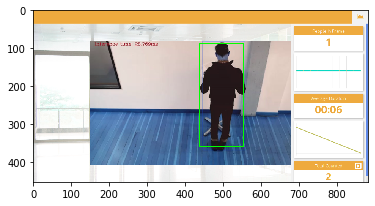

In [35]:
img = cv2.imread(r"./images/people-counter-image.png")

plt.imshow(draw_box(img, output_tensors[0][0][0], img.shape[1], img.shape[0]))

In [46]:
%%timeit
image = cv2.imread(r"./images/people-counter-image.png").astype(np.float32)

output_tensors = inference(image)

# detection_boxes = output_tensors[0]
# print(detection_boxes)
# detection_scores = output_tensors[1]
# print(detection_scores)
# num_detections = output_tensors[2]
# print(num_detections)
# detection_classes = output_tensors[3]
# print(detection_classes)

5.24 s ± 74.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:

from inference import Network
from helpers import preprocessing, ssd_boxes_counting, total_new, draw_boxes

In [48]:
infer_network = Network()
# Set Probability threshold for detections
prob_threshold = 0.5
### Load the model through `infer_network` ###
infer_network.load_model('./frozen_inference_graph.xml', 'CPU', None)
net_input_shape = infer_network.get_input_shape()

In [56]:
%%time

image = cv2.imread(r"./images/people-counter-image.png").astype(np.float32)
_frame = preprocessing(image, (net_input_shape[3], net_input_shape[2]))
### Start asynchronous inference for specified request ###
infer_network.exec_net(_frame)
while True:
    if infer_network.wait() == 0:
        ### Get the results of the inference request ###
        result = infer_network.get_output()
        break

20.9 ms ± 648 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [67]:
def draw_box_2(frame, box, width, height):
    '''
    Draw bounding boxes onto the frame.
    '''
    xmin = int(box[0] * width)
    ymin = int(box[1] * height)
    xmax = int(box[2] * width)
    ymax = int(box[3] * height)
    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    return frame

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


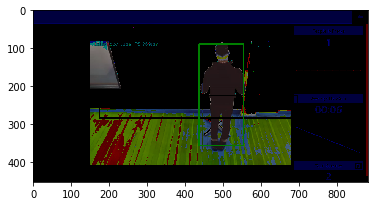

In [68]:
plt.imshow(draw_box_2(np.int8(image), result[0][0][0][3:], image.shape[1], image.shape[0]))

In [75]:
result[0][0][0]

array([0.        , 1.        , 0.9253446 , 0.4958756 , 0.19743714,
       0.62809944, 0.7885153 ], dtype=float32)

CPU times: user 2min 35s, sys: 8.34 s, total: 2min 43s
Wall time: 29.7 s


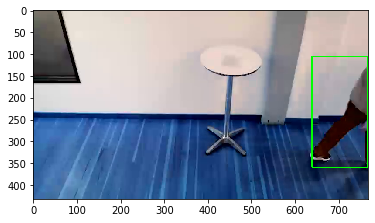

In [117]:
%%time

out_tt = []
count = 0
cap = cv2.VideoCapture("./resources/Pedestrian_Detect_2_1_1.mp4")
b = 0
while cap.isOpened():
    ### Read from the video capture ###
    flag, frame_raw = cap.read()
    width = int(cap.get(3))
    height = int(cap.get(4))
    
    if not flag:
        break
    _frame = preprocessing(frame_raw, (net_input_shape[3], net_input_shape[2]))
    infer_network.exec_net(_frame)
    while True:
        if infer_network.wait() == 0:
            ### Get the results of the inference request ###
            result = infer_network.get_output()
            out_tt.append(result)
            count += 1
            if result[0][0][0][1] == 1 and result[0][0][0][2] > 0.5:
#                 print('frame', count)
                out = draw_box_2(frame_raw, result[0][0][0][3:], width, height)
                b = 2
                plt.imshow(out)
            break
    if b == 1:
        break

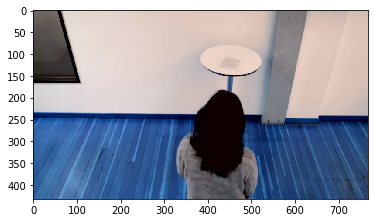

In [148]:
cap = cv2.VideoCapture("./resources/Pedestrian_Detect_2_1_1.mp4")
cap.set(1, 927);

ret, frame = cap.read()
plt.imshow(frame)

In [153]:
count = 0
for i, (t, tt) in enumerate(zip(out_t, out_tt)):
    if (t[1][0, 0] > 0.6 or tt[0, 0, 0, 2] > 0.6) and not (t[1][0, 0] > 0.6 and tt[0, 0, 0, 2] > 0.6):
        if t[1][0, 0] < 0.6:
#         if tt[0, 0, 0, 2] < 0.6:
            count += 1
            print(i, t[1][0, 0], tt[0, 0, 0, 2])
print(count)

64 0.5246174 0.725886
242 0.59102136 0.7178076
623 0.5473034 0.6446421
624 0.5842401 0.73887914
625 0.53329927 0.7063681
626 0.55387175 0.6791041
627 0.5103689 0.61471444
628 0.5870081 0.68639505
629 0.53334 0.6319322
630 0.56118655 0.70741713
631 0.57519776 0.7508891
632 0.5714631 0.716514
633 0.59982294 0.74367595
634 0.48190457 0.6537625
635 0.58734196 0.79248613
654 0.51050663 0.680869
655 0.52461493 0.66090226
926 0.32438457 0.8184538
927 0.0 0.7858317
1008 0.5679698 0.6208519
1009 0.58309484 0.62548435
1131 0.5594215 0.61919415
1132 0.593607 0.6449948
1133 0.5848635 0.632794
1136 0.5976975 0.62426174
1160 0.59939086 0.6056473
1170 0.596356 0.64624625
1171 0.5874288 0.65140855
1172 0.5908508 0.64427835
1355 0.5903779 0.61563444
30
